<h2> 3. Data cleaning and PCA </h2>

In [1]:
import sys, os; sys.path.insert(0, os.path.dirname(os.getcwd()))
import pandas as pd
import utils.io
import numpy as np
import math
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4.5)
plt.style.use('ggplot')

# Environment settings:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_column', None)

Load country indicators and countries tables with the needed dataframe format

In [2]:
data = utils.io.retrieve_table('CountryIndicators')
data = pd.pivot(data, index = ['CountryCode', 'Year'], columns = ['IndicatorCode'], values = 'Value').reset_index()
data_countries = utils.io.retrieve_table('Countries')

### Clean the data
There are a lot of NaN in the database. It is needed to clean the data, either by discarding samples with too many NaNs or removing maybe some indicators.

We see the proportion of NaNs in each column

In [3]:
data.isnull().mean()

IndicatorCode
CountryCode                 0.000000
Year                        0.000000
AG.AGR.TRAC.NO              0.424942
AG.CON.FERT.PT.ZS           0.922362
AG.CON.FERT.ZS              0.869413
                              ...   
per_sa_allsa.ben_q1_tot     0.990395
per_sa_allsa.cov_pop_tot    0.988727
per_si_allsi.adq_pop_tot    0.989998
per_si_allsi.ben_q1_tot     0.989998
per_si_allsi.cov_pop_tot    0.989442
Length: 1330, dtype: float64

Proportion of NaNs per row

In [4]:
data.isnull().mean(axis = 1)

0        0.975940
1        0.972932
2        0.972180
3        0.972932
4        0.972932
           ...   
12592    0.451128
12593    0.440602
12594    0.457143
12595    0.450376
12596    0.426316
Length: 12597, dtype: float64

Proportion of NaNs per year. <br>

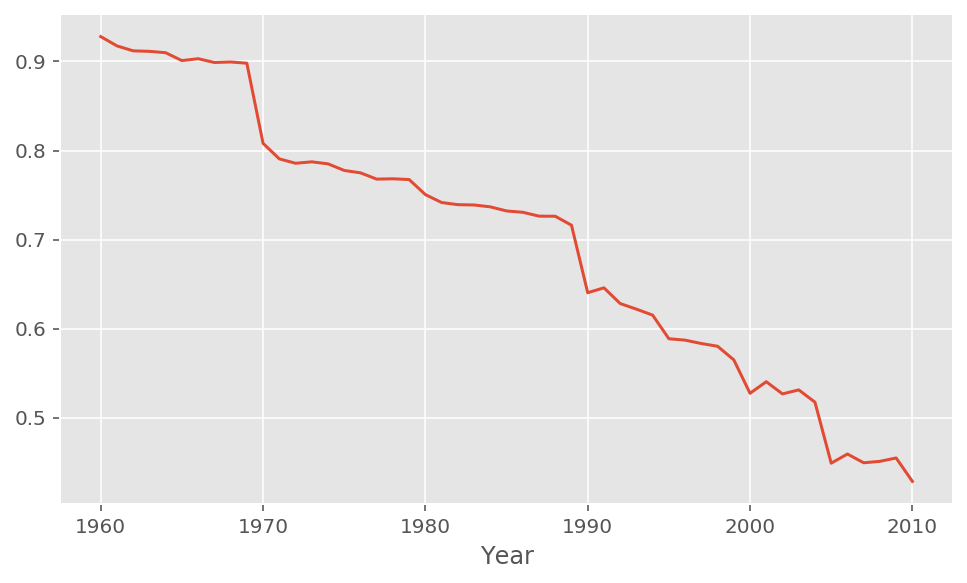

In [5]:
data.isnull().mean(axis = 1).groupby(data['Year']).mean().plot()

In [3]:
def clean_data_cols_nan(data, percentage_min_not_nans, from_year):
    data = data.loc[:, data[data['Year'] >= from_year].isnull().mean() < (1 - percentage_min_not_nans/100)]
    return data

We discard the indicators that have more than 30% of NaN values

In [4]:
cleaned_data = clean_data_cols_nan(data, 70, 1990); cleaned_data

IndicatorCode,CountryCode,Year,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.C

Merge function join two dataframes by a same columns. We add the Region and IncomeGroup columns from data_countries to our main dataframe

In [8]:
countrycodes_regions_incomegroup = data_countries.loc[:, ['CountryCode', 'Region', 'IncomeGroup', 'LongName']].drop_duplicates()
joined_data = pd.merge(cleaned_data, countrycodes_regions_incomegroup, on = 'CountryCode', how = 'outer')
joined_data

In [9]:
list_variables = list(joined_data)
list_variables.remove('Year')
joined_data.groupby('IncomeGroup')[list_variables].mean()

,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.MRCH.HI.ZS,TM.VAL.

Substitute NaN values with the mean value of the IncomeGroup for each indicator

In [10]:
def substitute_nans(data):
    data = data.fillna(data.groupby(['IncomeGroup', 'Year']).transform('mean')) # first fill by incomegroup and year
    data = data.fillna(data.groupby(['IncomeGroup']).transform('mean')) # fill the remaining by incomegroup only
    data = data.fillna(data.groupby(['Year']).transform('mean')) # fill the remaining, which don't have any income group, by year
    return data

In [11]:
data = substitute_nans(joined_data); data

,CountryCode,Year,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.M

##### Check if there is still NaNs

In [12]:
data.isnull().sum().sum()

0

#### Reducting indicators

In order to see which are the 50 indicators that explain the better our problem we use the principal component analysis

In [13]:
def principal_components(data, n_components):
    numeric_data = data.drop(['CountryCode', 'Region', 'IncomeGroup', 'LongName', 'Year'], axis = 1)
    normalized_data = StandardScaler().fit(numeric_data).transform(numeric_data)
    pca = PCA(n_components, svd_solver = 'arpack')
    pca.fit(normalized_data)
    print('Porcentage that our', n_components, 'components explain about the dataset ---->', pca.explained_variance_ratio_.sum())
    i = np.identity(numeric_data.shape[1])
    data_pca = pd.DataFrame(pca.transform(i), columns = ['PC-' + str(k) for k in range(1, n_components + 1)], index = numeric_data.columns)

    #plot
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return data_pca

Porcentage that our 50 components explain about the dataset ----> 0.8736364867884243


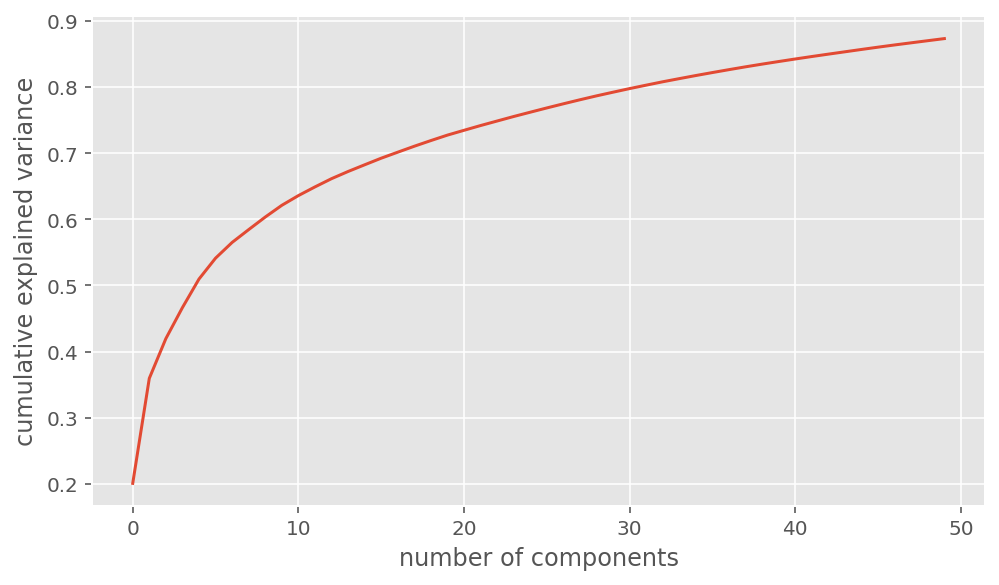

In [14]:
pca_data = principal_components(data, 50); pca_data;

We take the indicators that have more relation with the each principal component

In [15]:
def choose_relevant_columns(data):
    indicators = []
    for col in list(data):
        indicator = data[col].idxmax()
        data.drop(indicator)
        indicators.append(indicator)
    return indicators

And finally we have the data with the 50 more explicative indicators and without NaN values

In [16]:
more_relevant_columns_data = choose_relevant_columns(pca_data);
data = data.loc[:, ['CountryCode', 'LongName', 'Region', 'IncomeGroup', 'Year'] + more_relevant_columns_data]
data

,CountryCode,LongName,Region,IncomeGroup,Year,IT.MLT.MAIN,SH.DYN.NMRT,SL.TLF.ACTI.ZS,NE.DAB.TOTL.CN,NV.SRV.TETC.CD,NY.GDP.TOTL.RT.ZS,NE.IMP.GNFS.ZS,NY.ADJ.DCO2.GN.ZS,TX.VAL.MRCH.AL.ZS,SL.TLF.ACTI.1524.MA.ZS,NY.ADJ.AEDU.CD,NY.GDP.PCAP.KD.ZG,NE.IMP.GNFS.ZS,DC.DAC.CECL.CD,SP.POP.GROW,NY.GDP.PCAP.KD.ZG,SL.UEM.TOTL.ZS,SE.PRM.ENRR.MA,NE.CON.GOVT.ZS,NY.ADJ.DMIN.GN.ZS,TX.VAL.MRCH.RS.ZS,SE.SEC.AGES,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,NY.GDP.DEFL.KD.ZG,TX.VAL.MRCH.HI.ZS,FP.CPI.TOTL.ZG,FP.CPI.TOTL.ZG,NY.ADJ.DMIN.CD,NY.ADJ.AEDU.GN.ZS,TX.VAL.MRCH.R5.ZS,ER.LND.PTLD.ZS,SP.POP.GROW,NY.ADJ.DFOR.GN.ZS,MS.MIL.TOTL.TF.ZS,EN.POP.DNST,NE.RSB.GNFS.CN,DT.ODA.ODAT.PC.ZS,DT.ODA.ODAT.PC.ZS,TG.VAL.TOTL.GD.ZS,EG.ELC.RNEW.ZS,NV.IND.MANF.KD.ZG,NY.GDP.DEFL.ZS,DT.ODA.ODAT.PC.ZS,NY.GDP.COAL.RT.ZS,DT.ODA.ODAT.PC.ZS,SP.RUR.TOTL.ZG,TX.VAL.MRCH.R6.ZS,NV.IND.MANF.KD.ZG,NY.GDP.COAL.RT.ZS
0,ABW,Aruba,Latin America & Caribbean,High income: nonOECD,1960,7.563256e+04,9.329453,68.844007,1.890545e+09,2.171675e+10,19.571903,63.570110,0.594515,1.365784,54.264368,1.531481e+09,2.990284,63.570110,7.439954e+06,3.134888,2.990284,7.58375,103.038207,10.019560,0.170571,13.415277,11.596667,9.854553,14.792243,16.129636,74.826305,14.792243,14.792243,4.776911e+07,3.642575,1.594081,15.330320,3.134888,0.134684,2.444459,1040.715738,-1.888684e+08,39.311428,39.311428,104.700856,13.050031,5.020900,18.347623,39.311428,0.009279,39.311428,3.163869,1.126726,5.020900,0.009279
1,ABW,Aruba,Latin America & Caribbean,High income: nonOECD,1961,1.020418e+06,9.329453,68.844007,2.122151e+09,2.171675e+10,19.571903,57.050601,0.594515,1.536747,54.264368,1.531481e+09,2.456528,57.050601,7.439954e+06,2.238266,2.456528,7.58375,103.038207,10.252043,0.170571,16.973569,11.596667,9.854553,5.313192,4.384058,74.723914,5.313192,5.313192,4.776911e+07,3.642575,2.097956,15.330320,2.238266,0.134684,2.444459,307.972222,-1.957382e+08,40.905492,40.905492,97.030610,13.050031,6.255834,18.726161,40.905492,0.009279,40.905492,2.271351,1.184994,6.255834,0.009279
2,ABW,Aruba,Latin America & Caribbean,High income: nonOECD,1962,1.020418e+06,9.329453,68.844007,2.306136e+09,2.171675e+10,19.571903,55.891428,0.594515,1.748848,54.264368,1.531481e+09,4.045457,55.891428,7.439954e+06,1.416812,4.045457,7.58375,103.038207,11.466887,0.170571,23.057545,11.596667,9.854553,2.916446,5.565626,75.422428,2.916446,2.916446,4.776911e+07,3.642575,1.500470,15.330320,1.416812,0.134684,2.444459,312.366667,-1.504209e+08,53.086027,53.086027,132.069492,13.050031,9.446662,19.247583,53.086027,0.009279,53.086027,1.447561,1.038216,9.446662,0.009279
3,ABW,Aruba,Latin America & Caribbean,High income: nonOECD,1963,1.020418e+06,9.329453,68.844007,2.573825e+09,2.171675e+10,19.571903,53.044131,0.594515,1.396659,54.264368,1.531481e+09,2.306154,53.044131,7.439954e+06,0.834202,2.306154,7.58375,103.038207,11.043471,0.170571,17.845580,11.596667,9.854553,6.211243,6.112780,78.977572,6.211243,6.211243,4.776911e+07,3.642575,0.895270,15.330320,0.834202,0.134684,2.444459,314.983333,-1.192038e+08,90.082154,90.082154,127.082830,13.050031,5.720478,19.649732,90.082154,0.009279,90.082154,0.866460,3.957685,5.720478,0.009279
4,ABW,Aruba,Latin America & Caribbean,High income: nonOECD,1964,1.020418e+06,9.329453,68.844007,2.890033e+09,2.171675e+10,19.571903,51.491706,0.594515,2.261134,54.264368,1.531481e+09,3.650526,51.491706,7.439954e+06,0.583861,3.650526,7.58375,103.038207,10.761491,0.170571,11.168794,11.596667,9.854553,8.272703,8.123016,81.353322,8.272703,8.272703,4.776911e+07,3.642575,0.303070,15.330320,0.583861,0.134684,2.444459,316.827778,-1.478481e+08,62.815762,62.815762,114.952174,13.050031,12.018207,20.119988,62.815762,0.009279,62.815762,0.613827,2.975539,12.018207,0.009279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592,ZWE,Republic of Zimbabwe,Sub-Saharan Africa,Low income,2006,3.355610e+05,23.700000,87.400